In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pickle

from tracking_data.dataset import Dataset_TailTracking,Dataset_CentroidTracking
from pipeline.cfg import ConfigTrajPreprocess,ConfigTrajSegmentationClassification
from pipeline.centroid_tracking import  PipelineCentroidTracking

from utils.utils_plot import display_trajectory
from utils.utils import compute_outer_circle
from utils import smallestenclosingcircle as smallestenclosingcircle
from super_resolution.downsampling import convert_frame_duration,create_downsampling_function

from utils.utils_bouts import NameCat

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors



# Load results

In [65]:
import pickle

from utils.utils_bouts import compute_bout_cat_ts
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score


In [70]:

fps_list = np.linspace(30,700,30)
fps_list = 10*np.round(fps_list/10).astype('int')

peak_prominence_list = np.linspace(0.1,1,30)


folder='D://ZebrafishMatlabCSV//'
folder_fulltrack = 'G://Megabouts_dataset//Full_Tracking_Pipeline//'
folder_result = 'G://Megabouts_dataset//Super_Resolution_Pipeline//'
file_input_list=[]
file_fulltrack_list = []
file_result_list = []

for file in os.listdir(folder):
    if file.endswith(".csv"):
        file_input_list.append(os.path.join(folder, file))
        file_fulltrack_list.append(os.path.join(folder_fulltrack, file[:-7])+'.pickle')
        file_result_list.append(os.path.join(folder_result, file[:-7]))
        
id_rnd = np.random.RandomState(seed=42).permutation(np.arange(0,len(file_input_list)))[0:20]

file_input_list = np.array(file_input_list)[id_rnd]
file_fulltrack_list = np.array(file_fulltrack_list)[id_rnd]
file_result_list = np.array(file_result_list)[id_rnd]
        
Accuracy_Segmentation = np.zeros((len(fps_list),len(file_result_list)))
Accuracy_Classification = np.zeros((len(fps_list),len(file_result_list)))
Accuracy_ClassificationSym = np.zeros((len(fps_list),len(file_result_list)))
F1Score = np.zeros((len(fps_list),len(file_result_list)))

DictLabel = {}


for j_param,(fps_new,peak_pro) in enumerate(zip(fps_list,peak_prominence_list)):
        
    y_true,y_pred = [],[]
    
    for i_fish,(filename,filename_fulltrack,filename_result) in enumerate(zip(file_input_list,file_fulltrack_list,file_result_list)):
        
        print(i_fish)
        # Load Full Tracking Results:    
        with open(filename_fulltrack, 'rb') as handle:
                    pipeline_full_results = pickle.load(handle)

        # Extract Python Results
        pipeline_results_full_tracking = pipeline_full_results['pipeline']

        segments_full = pipeline_results_full_tracking['segments']
        bout_cat_full = pipeline_results_full_tracking['bout_cat']
        onset_full = np.array(segments_full.onset)
        offset_full = np.array(segments_full.offset)
        bout_cat_ts_full,bout_cat_ts_signed_full = compute_bout_cat_ts(segments_full.onset,segments_full.offset,bout_cat_full,pipeline_results_full_tracking['tracking_data'].n_frames)
        T_full = pipeline_results_full_tracking['tracking_data'].n_frames

        
        # Load Super-resolution results:
        filename_results_fps = f"{filename_result}_fps{fps_new:03d}.pickle"                
        with open(filename_results_fps, 'rb') as handle:
                    pipeline_results = pickle.load(handle)
                    
        segments = pipeline_results['segments']
        onset_super_res = segments.onset
        onset_super_res = np.array(onset_super_res)
        bout_cat_super_res = pipeline_results['bout_cat']
        downsampling_f, Duration_after_Downsampling,original_t,new_t = create_downsampling_function(fps_new=fps_new,fps_origin=700,duration_ms=T_full*1000/700)

        # Match bouts from two time series:
        delta_t = 50 
        label_full = []
        label_super = []

        N_match = 0
        for on_,cat_full in zip(onset_full,bout_cat_full):
            if np.min(np.abs(original_t[on_]-new_t[onset_super_res]))<delta_t:
                id_super = np.argmin(np.abs(original_t[on_]-new_t[onset_super_res]))
                cat_super = bout_cat_super_res[id_super]
                N_match = N_match+1
                label_full.append(cat_full)
                label_super.append(cat_super)
        
        
        Accuracy_Segmentation[j_param,i_fish] =  N_match/len(bout_cat_full)
        
        x = np.array(label_full)
        y = np.array(label_super)
        
        # Match bouts from two time series:
        Accuracy_Classification[j_param,i_fish] =  balanced_accuracy_score(x, y)
        Accuracy_ClassificationSym[j_param,i_fish] =  balanced_accuracy_score(x%13, y%13)
        F1Score[j_param,i_fish] =  f1_score(x, y, average='weighted')

        y_true = y_true+label_full
        y_pred = y_pred+lab

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


KeyboardInterrupt: 

array([ 30,  50,  80, 100, 120, 150, 170, 190, 210, 240, 260, 280, 310,
       330, 350, 380, 400, 420, 450, 470, 490, 520, 540, 560, 580, 610,
       630, 650, 680, 700])

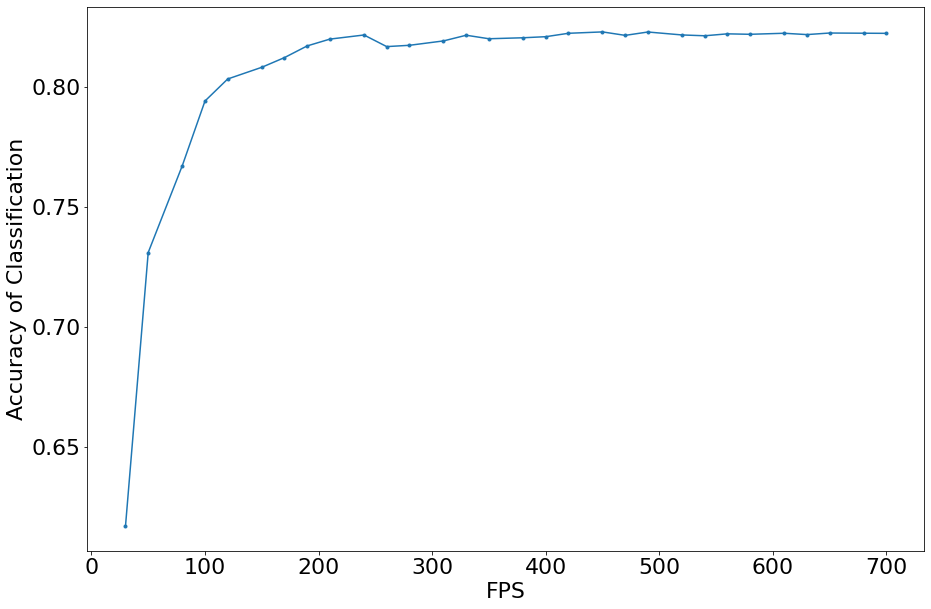

"\nfrom matplotlib.patches import Patch\nfrom matplotlib.lines import Line2D\n\nlegend_elements = [Line2D([0], [0], color='k', lw=1, label='Zebrafish'),\n                   Line2D([0], [0], color='k',ls='--',label='Giant'),\n                   Line2D([0], [0], color='b',ls='--',label='Slow Bouts'),\n                   Line2D([0], [0], color='r',ls='--',label='Fast Bouts')]\n                   \nax.legend(handles=legend_elements, loc='upper left')\n\n"

In [88]:
#plt.plot(np.mean(Accuracy_Classification[:,:-1],axis=1))
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(15,10))
plt.plot(np.array(fps_list),np.mean(Accuracy_ClassificationSym[:,:-1],axis=1),'.-')
#plt.plot(np.array(fps_list),np.mean(Accuracy_Segmentation[:,:-1],axis=1))

plt.xlabel('FPS')
plt.ylabel('Accuracy of Classification')
plt.show()

'''
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='k', lw=1, label='Zebrafish'),
                   Line2D([0], [0], color='k',ls='--',label='Giant'),
                   Line2D([0], [0], color='b',ls='--',label='Slow Bouts'),
                   Line2D([0], [0], color='r',ls='--',label='Fast Bouts')]
                   
ax.legend(handles=legend_elements, loc='upper left')

'''


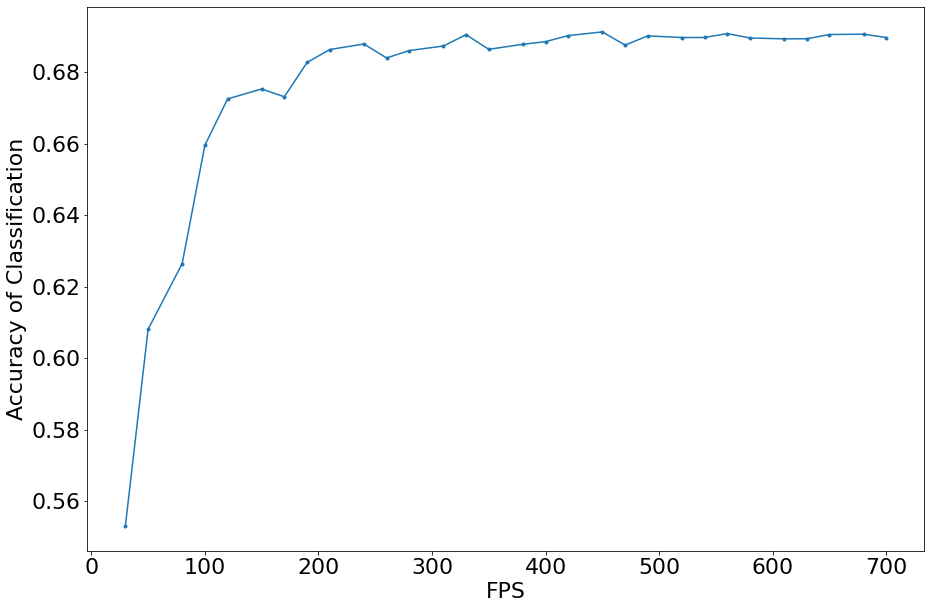

In [89]:
#plt.plot(np.mean(Accuracy_Classification[:,:-1],axis=1))
plt.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(15,10))
plt.plot(np.array(fps_list),np.mean(F1Score[:,:-1],axis=1),'.-')
#plt.plot(np.array(fps_list),np.mean(Accuracy_Segmentation[:,:-1],axis=1))

plt.xlabel('FPS')
plt.ylabel('F1 Score')
plt.show()


# Save for Tracking Scope

In [93]:
with open(filename_fulltrack, 'rb') as handle:
                    pipeline_full_results = pickle.load(handle)

# Extract Python Results
pipeline_results_full_tracking = pipeline_full_results['pipeline']

segments_full = pipeline_results_full_tracking['segments']
bout_cat_full = pipeline_results_full_tracking['bout_cat']
onset_full = np.array(segments_full.onset)
offset_full = np.array(segments_full.offset)
bout_cat_ts_full,bout_cat_ts_signed_full = compute_bout_cat_ts(segments_full.onset,segments_full.offset,bout_cat_full,pipeline_results_full_tracking['tracking_data'].n_frames)
T_full = pipeline_results_full_tracking['tracking_data'].n_frames


In [101]:
pipeline_results_full_tracking.keys()

dict_keys(['tracking_data', 'clean_traj', 'baseline', 'tail_angle_detrend', 'z', 'segments', 'tail_and_traj_array', 'bout_cat'])

In [94]:
bout_cat_ts_full.shape,np.unique(bout_cat_ts_full)

((7668382,),
 array([-1.,  0.,  1.,  2.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]))

In [97]:
NameCat[12]

'C_start+'

In [126]:
np.where(bout_cat_ts_full==12)[0][0:1000]

array([ 46138,  46139,  46140,  46141,  46142,  46143,  46144,  46145,
        46146,  46147,  46148,  46149,  46150,  46151,  46152,  46153,
        46154,  46155,  46156,  46157,  46158,  46159,  46160,  46161,
        46162,  46163,  46164,  46165,  46166,  46167,  46168,  46169,
        46170,  46171,  46172,  46173,  46174,  46175,  46176,  46177,
        46178,  46179,  46180,  46181,  46182,  46183,  46184,  46185,
        46186,  46187,  46188,  46189,  46190,  46191,  46192,  46193,
        46194,  46195,  46196,  46197,  46198,  46199,  46200,  46201,
        46202,  46203,  46204,  46205,  46206,  46207,  46208,  46209,
        46210,  46211,  46212,  46213,  46214,  46215,  46216,  46217,
        46218,  46219,  46220,  46221,  46222,  46223,  46224,  46225,
        46226,  46227,  46228,  46229,  46230,  46231,  46232,  46233,
        46234,  46235,  46236,  46237,  46238,  46239,  46240,  46241,
        46242,  46243,  46244,  46245,  46246,  46247,  46248,  46249,
      

In [ ]:
plt.plot(tail)

In [151]:
pipeline_results_full_tracking.keys()

dict_keys(['tracking_data', 'clean_traj', 'baseline', 'tail_angle_detrend', 'z', 'segments', 'tail_and_traj_array', 'bout_cat'])

In [152]:
id_st = 73421-700*3
duration = 700*30
x_ = pipeline_results_full_tracking['tracking_data'].x[id_st:id_st+duration]
y_ = pipeline_results_full_tracking['tracking_data'].y[id_st:id_st+duration]
tail_ = pipeline_results_full_tracking['tail_angle_detrend'][id_st:id_st+duration]

x_smooth = pipeline_results_full_tracking['clean_traj'].x[id_st:id_st+duration]
y_smooth = pipeline_results_full_tracking['clean_traj'].y[id_st:id_st+duration]

t = np.arange(duration)

x_,y_ = x_-x_[0],y_-y_[0]
x_smooth,y_smooth = x_smooth-x_smooth[0],y_smooth-y_smooth[0]


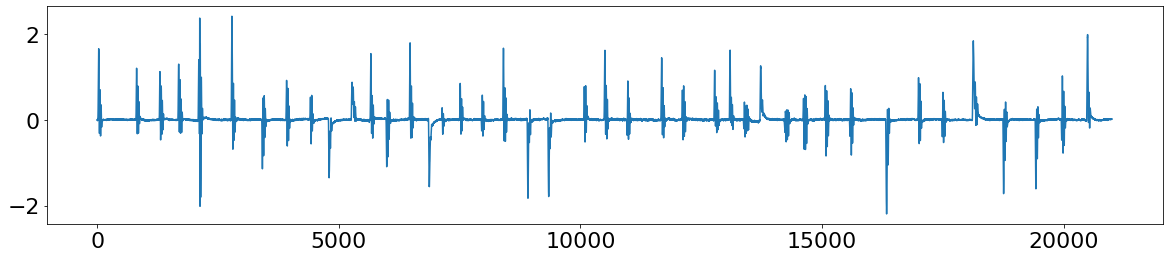

In [153]:
plt.figure(figsize=(20,4))
plt.plot(tail_[:,-1])

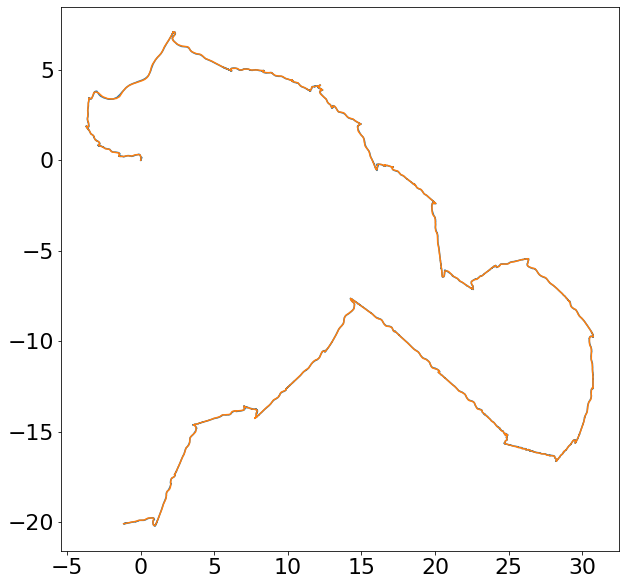

In [161]:
plt.figure(figsize=(10,10))
plt.plot(x_,y_)
plt.plot(x_smooth,y_smooth)

In [162]:
np.max(x_-x_smooth)

0.10599319746314428

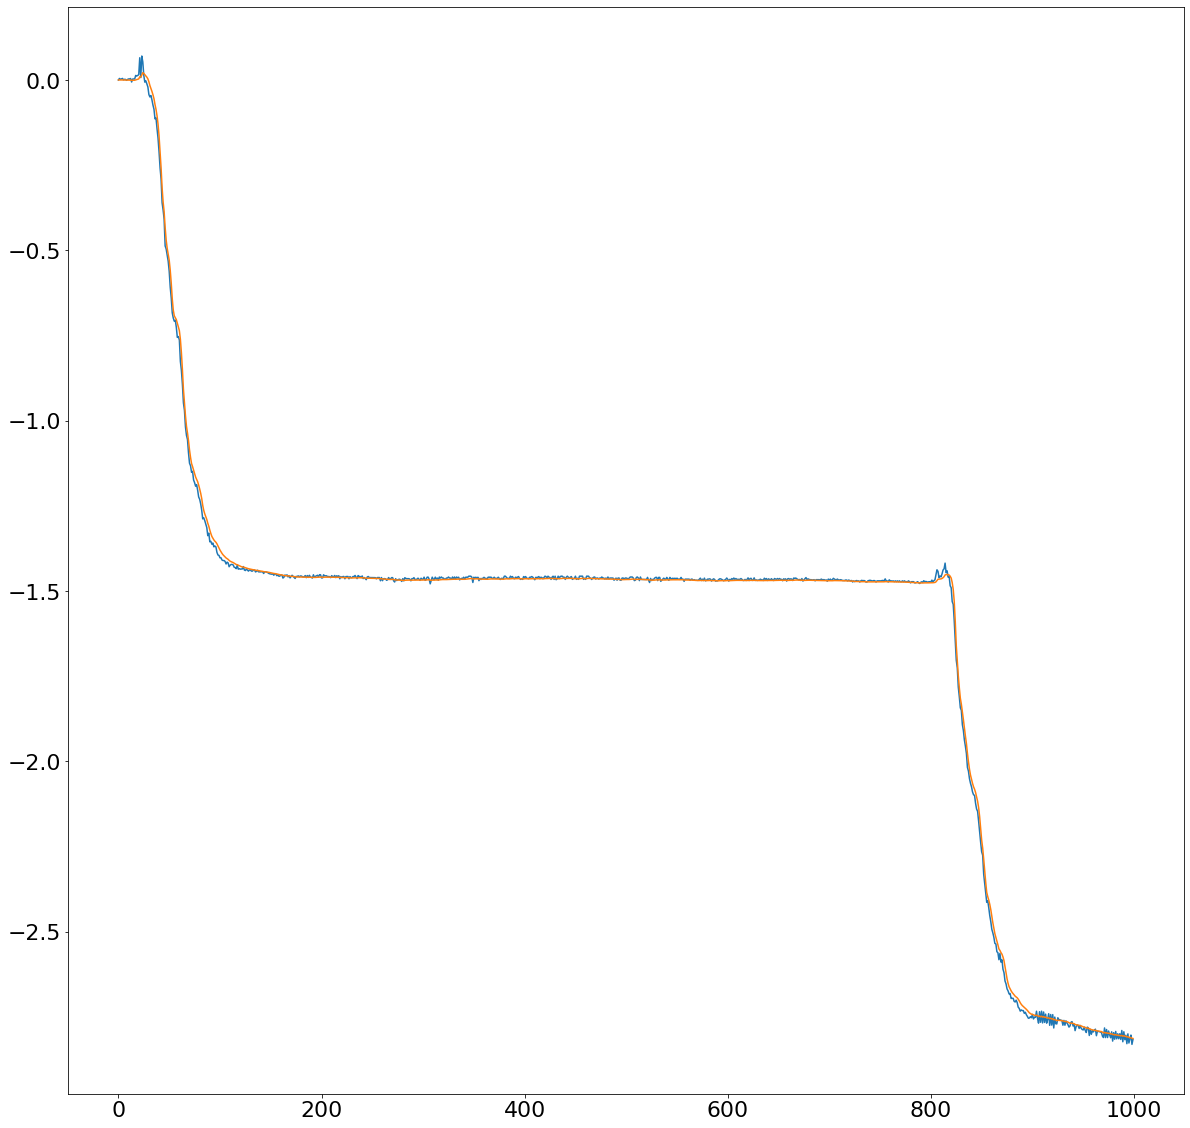

In [156]:
plt.figure(figsize=(20,20))
plt.plot(x_[0:1000])
plt.plot(x_smooth[0:1000])

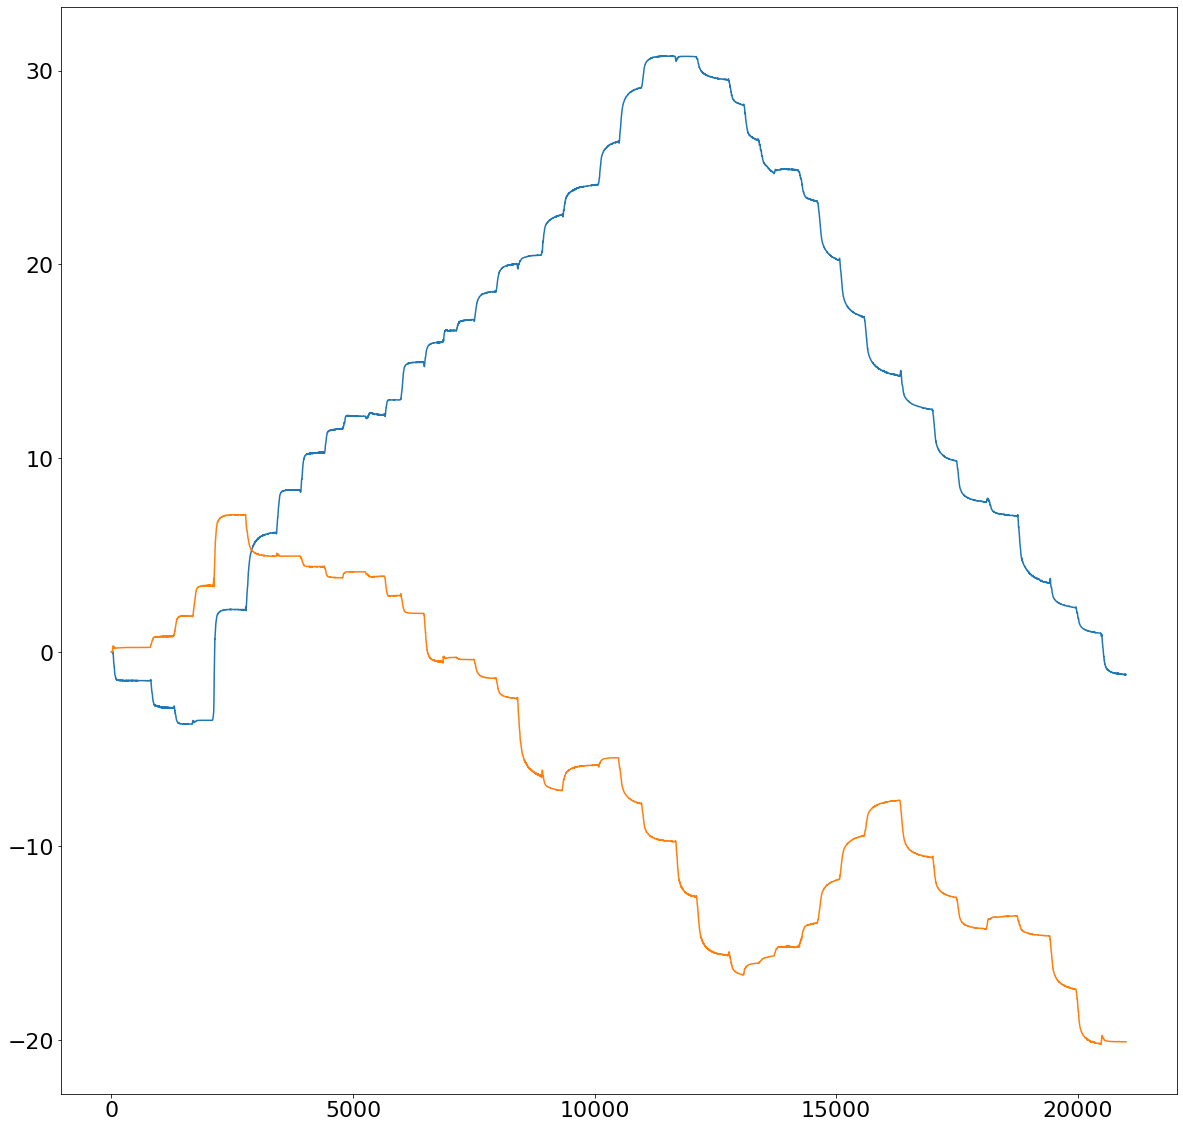

In [155]:
plt.figure(figsize=(20,20))
plt.plot(x_)
plt.plot(y_)

In [163]:
import scipy.io
import numpy as np



file_path = 'trajectory.mat'
scipy.io.savemat(file_path, {'x': x_,'y':y_,'x_smooth':x_smooth,'y_smooth':y_smooth})

### Display Example Confusion Matrix

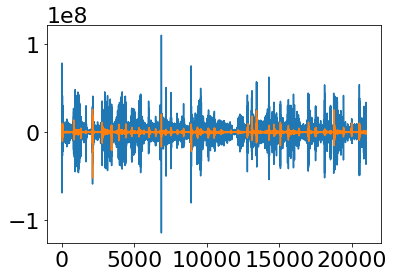

In [169]:
6t5f
vel = np.diff(x_)*700
acc = np.diff(vel)*700
jerk = np.diff(acc)*700

plt.plot(jerk)


vel = np.diff(x_smooth)*700
acc = np.diff(vel)*700
jerk = np.diff(acc)*700

plt.plot(jerk)


## Load Dataset:

In [3]:
# Find already processed files

# Select randomly 10 fish

# Start with original fps maximize parameters

# Apply pipeline over a range of fps

In [69]:

folder = 'G://Megabouts_dataset//Full_Tracking_Pipeline//'
file_list=[]
for file in os.listdir(folder):
    if file.endswith(".pickle"):
        file_list.append(os.path.join(folder, file))
 
for i_f,filename in enumerate(file_list):
    
    print(i_f)
    with open(filename, 'rb') as handle:
                pipeline_results = pickle.load(handle)
    
    # Extract Python Results
    pipeline = pipeline_results['pipeline']
    '''
    segments = pipeline['segments']
    bout_cat = pipeline['bout_cat']
    tail_and_traj_array = pipeline['tail_and_traj_array']
    tail_angle = pipeline['tail_angle_detrend']
    onset_py = segments.onset
    offset_py = segments.offset'''
    break
    
    

0


In [72]:
filename

'G://Megabouts_dataset//Full_Tracking_Pipeline//CatchAllBouts_atlas_20200525_1551.pickle'

In [83]:


folder='D://ZebrafishMatlabCSV//'
folder_result = 'G://Megabouts_dataset//Full_Tracking_Pipeline//'
file_input_list=[]
file_result_list = []
for file in os.listdir(folder):
    if file.endswith(".csv"):
        file_input_list.append(os.path.join(folder, file))
        file_result_list.append(os.path.join(folder_result, file[:-7])+'.pickle')


##### RUN PIPELINE OVER ALL FISH #####

for filename,filename_result in zip(file_input_list[:],file_result_list[:]):
    print(filename,filename_result)
    break

D://ZebrafishMatlabCSV//CatchAllBouts_atlas_20200525_1551_df.csv G://Megabouts_dataset//Full_Tracking_Pipeline//CatchAllBouts_atlas_20200525_1551.pickle


In [84]:
pipeline.keys()

AttributeError: 'PipelineCentroidTracking' object has no attribute 'keys'

In [ ]:
# For each bouts in original dataset
# Do you find a bouts in smaller fps (segmentation accuracy)
# Do you find the same label as in the original fps (classification accuracy)

In [ ]:
# Instead of notebook:

# Make .py file to go over fps and for each fps compute super-resolution:

# 

### Load 700 fps result

In [87]:
with open(filename_result, 'rb') as handle:
                pipeline_results = pickle.load(handle)
    
# Extract Python Results
pipeline = pipeline_results['pipeline']
    
segments = pipeline['segments']
bout_cat = pipeline['bout_cat']
tail_and_traj_array = pipeline['tail_and_traj_array']
tail_angle = pipeline['tail_angle_detrend']
onset_py = segments.onset
offset_py = segments.offset


In [88]:
bout_cat

array([18, 15, 15, ...,  5, 14, 21])

### Load data to subsample

In [86]:
df = pd.read_csv(filename)

x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)


In [ ]:
tracking_tail_data = Dataset_TailTracking(fps=700,tail_angle=tail_angle)

# Downsample:
fps_new = 700
downsampling_f, Duration_after_Downsampling,t,tnew = create_downsampling_function(fps_new=fps_new,n_frames_origin=len(x),fps_origin=700)
#x_sub = downsampling_f(x,axis = 0)
#y_sub = downsampling_f(y,axis = 0)
#body_angle_sub = downsampling_f(body_angle,axis = 0)
tail_angle_sub = downsampling_f(tail_angle,axis = 0)

x_sub,y_sub,body_angle_sub  = map(lambda x : downsampling_f(x,axis=0),[x,y,body_angle])

In [109]:

N_FPS = 30
N_Fish= 20

T_loadpipeline = 120 # sec
T_loadfish = 40 
T_runfish = 4*60

print(N_FPS*(T_loadpipeline+N_Fish*(T_loadfish+T_runfish))/(3600))

# 50 Hours to run every thing


fps = np.linspace(30,700,30)
fps = 10*np.round(fps/10).astype('int')
print(fps)

47.666666666666664
[ 30  50  80 100 120 150 170 190 210 240 260 280 310 330 350 380 400 420
 450 470 490 520 540 560 580 610 630 650 680 700]


In [89]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')

x = df['x_blob'].values
y = df['y_blob'].values
body_angle = df['body_angle'].values
body_angle = np.arctan2(np.sin(body_angle),np.cos(body_angle))
body_angle = np.unwrap(body_angle)
# Center trajectory:
circle = compute_outer_circle(x,y)
x,y = x-circle[0],y-circle[1]

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)


### Subsample

In [99]:
tracking_tail_data = Dataset_TailTracking(fps=700,tail_angle=tail_angle)

# Downsample:
fps_new = 90
downsampling_f, Duration_after_Downsampling,t,tnew = create_downsampling_function(fps_new=fps_new,fps_origin=700,duration_ms=len(x)*1000/700)
#x_sub = downsampling_f(x,axis = 0)
#y_sub = downsampling_f(y,axis = 0)
#body_angle_sub = downsampling_f(body_angle,axis = 0)
tail_angle_sub = downsampling_f(tail_angle,axis = 0)

x_sub,y_sub,body_angle_sub  = map(lambda x : downsampling_f(x,axis=0),[x,y,body_angle])

### Check Data

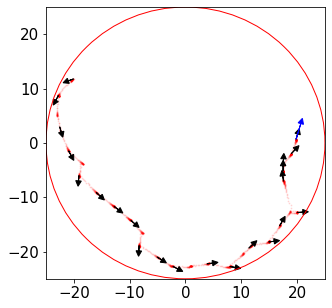

In [100]:
df_plot=pd.DataFrame(np.vstack((x_sub,y_sub,body_angle_sub)).T, 
columns=['x','y','angle'])
id = np.random.randint(df_plot.shape[0])
fig = display_trajectory(df_plot,index = id,past_memory=3*700)

# Parameters Tuning

### One euro filter

<font size="2">

The two parameters (fcmin and beta) can be set using a simple two-step procedure:
* First beta is set to 0 and fcmin (mincutoff) to a reasonable middle-ground value such as 1 Hz. Then the body part is held steady or moved at a very low speed while fcmin is adjusted to remove jitter and preserve an acceptable lag during these slow movements (decreasing fcmin reduces jitter but increases lag, fcmin must be > 0). 
* Next, the body part is moved quickly in different directions while beta is increased with a focus on minimizing lag. First find the right order of magnitude to tune beta, which depends on the kind of data you manipulate and their units: do not hesitate to start with values like 0.001 or 0.0001. You can first multiply and divide beta by factor 10 until you notice an effect on latency when moving quickly. 

Note that parameters fcmin and beta have clear conceptual relationships: if high speed lag is a problem, increase beta; if slow speed jitter is a problem, decrease fcmin.

</font>

In [101]:
from preprocessing.smoothing import one_euro_filter


In [102]:
# Find smooth epoch:
Duration = fps_new*5
is_fish_stationnary = False 
while not is_fish_stationnary:
    
    IdSt = np.random.randint(x_sub.shape[0]-Duration)
    
    x_,y_,angle_ = x_sub[IdSt:IdSt+Duration],y_sub[IdSt:IdSt+Duration],body_angle_sub[IdSt:IdSt+Duration]
    
    extent = np.max(angle_)-np.min(angle_)
    if extent<0.05:
        is_fish_stationnary=True


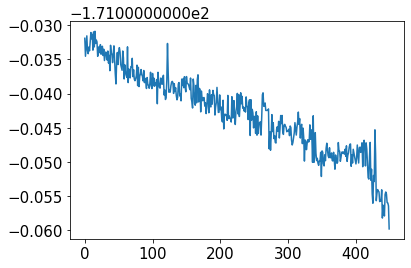

In [103]:

#plt.plot(x_sub[IdSt:IdSt+Duration])
#plt.plot(y_sub[IdSt:IdSt+Duration])
plt.plot(body_angle_sub[IdSt:IdSt+Duration])

(-171.13191194134177, -170.93191194134178)

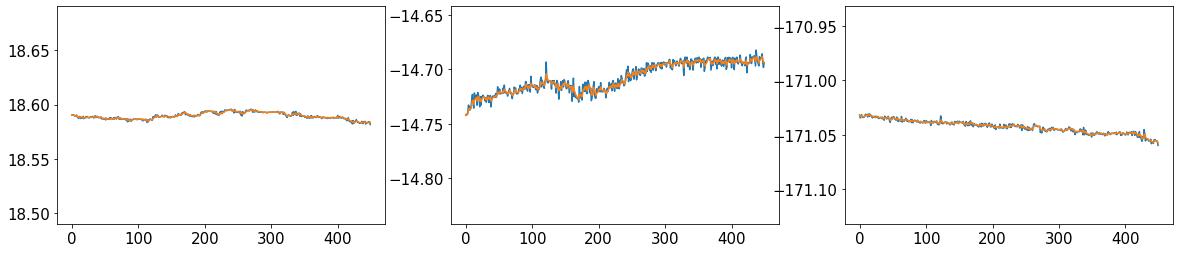

In [104]:
fc_min,beta = 10,0

smooth_func = lambda x : one_euro_filter(x,fc_min,beta,fps_new)
x_clean,y_clean,body_angle_clean  = map(smooth_func,[x_,y_,angle_])

IdSt,Duration = 0,len(x_)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(20,4))
Margin_Plot=0.1
ax1.plot(x_[IdSt:IdSt+Duration])
ax1.plot(x_clean[IdSt:IdSt+Duration])
ax1.set_ylim(x_[0]-Margin_Plot,x_[0]+Margin_Plot)
ax2.plot(y_[IdSt:IdSt+Duration])
ax2.plot(y_clean[IdSt:IdSt+Duration])
ax2.set_ylim(y_[0]-Margin_Plot,y_[0]+Margin_Plot)
ax3.plot(angle_[IdSt:IdSt+Duration])
ax3.plot(body_angle_clean[IdSt:IdSt+Duration])
ax3.set_ylim(angle_[0]-Margin_Plot,angle_[0]+Margin_Plot)


In [105]:
# Find fast movement epoch:
Duration = int(np.round(fps_new*0.2))
is_fish_stationnary = False 
while not is_fish_stationnary:
    
    IdSt = np.random.randint(x_sub.shape[0]-Duration)
    
    x_,y_,angle_ = x_sub[IdSt:IdSt+Duration],y_sub[IdSt:IdSt+Duration],body_angle_sub[IdSt:IdSt+Duration]
    
    extent = np.max(angle_)-np.min(angle_)
    if extent>3:
        is_fish_stationnary=True

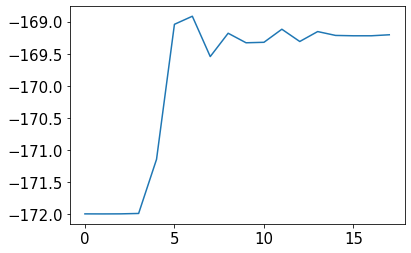

In [106]:
#plt.plot(x_sub[IdSt:IdSt+Duration])
#plt.plot(y_sub[IdSt:IdSt+Duration])
plt.plot(body_angle_sub[IdSt:IdSt+Duration])

(-174.9944601835123, -168.9944601835123)

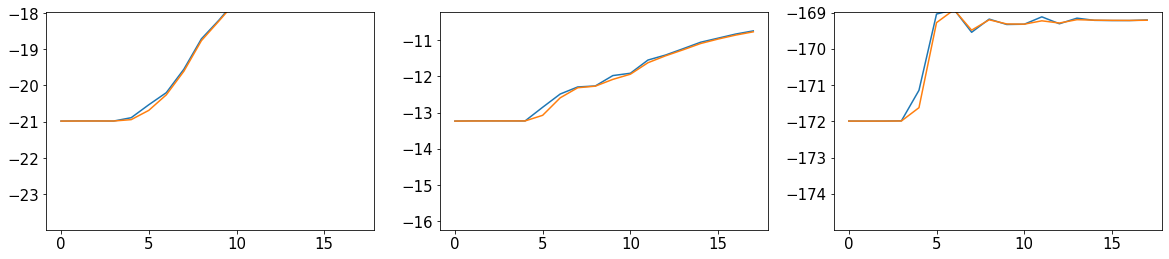

In [107]:
fc_min,beta = 10,4

smooth_func = lambda x : one_euro_filter(x,fc_min,beta,fps_new)
x_clean,y_clean,body_angle_clean  = map(smooth_func,[x_,y_,angle_])

IdSt,Duration = 0,len(x_)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(20,4))
Margin_Plot=3
ax1.plot(x_[IdSt:IdSt+Duration])
ax1.plot(x_clean[IdSt:IdSt+Duration])
ax1.set_ylim(x_[0]-Margin_Plot,x_[0]+Margin_Plot)
ax2.plot(y_[IdSt:IdSt+Duration])
ax2.plot(y_clean[IdSt:IdSt+Duration])
ax2.set_ylim(y_[0]-Margin_Plot,y_[0]+Margin_Plot)
ax3.plot(angle_[IdSt:IdSt+Duration])
ax3.plot(body_angle_clean[IdSt:IdSt+Duration])
ax3.set_ylim(angle_[0]-Margin_Plot,angle_[0]+Margin_Plot)


# Declare Pipeline

In [20]:
cfg_preprocess = ConfigTrajPreprocess(fps=700,freq_cutoff_min=10,beta=4)
cfg_segment_classify = ConfigTrajSegmentationClassification(fps=700,peak_prominence=0.4,N_kNN=10)
pipeline = PipelineCentroidTracking(cfg_preprocess,cfg_segment_classify,load_training=False)

## Peak Finding

In [23]:
from scipy.signal import find_peaks

In [24]:
cfg_preprocess = ConfigTrajPreprocess(fps=700,freq_cutoff_min=10,beta=4)
cfg_segment_classify = ConfigTrajSegmentationClassification(fps=700)

In [25]:
tracking_data = Dataset_CentroidTracking(fps=cfg_preprocess.fps,
                                         x=x_sub,
                                         y=y_sub,body_angle=body_angle_sub)
        
clean_traj = pipeline.preprocess(x=tracking_data.x,
                                 y=tracking_data.y,
                                 body_angle=tracking_data.body_angle)      

In [26]:
mobility = clean_traj.mobility

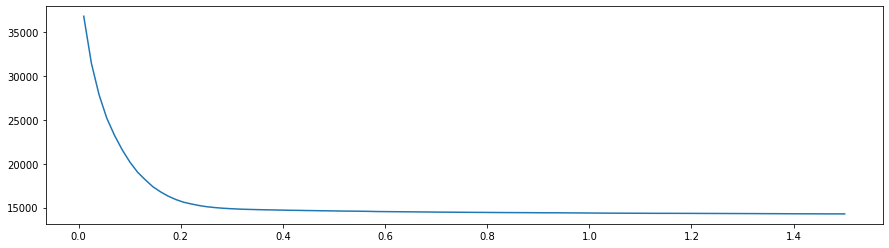

In [27]:
bout_duration = cfg_segment_classify.bout_duration
# Number of peak as function of prominence:
prom_para = np.linspace(0.01,1.5,100)
num_peaks = np.zeros_like(prom_para)
for i,pro in enumerate(prom_para):
    peaks, _ = find_peaks(mobility,distance=bout_duration,prominence=pro)
    num_peaks[i] = len(peaks)

plt.figure(figsize=(15,4))
plt.plot(prom_para,num_peaks)

# Run Pipeline

In [28]:
pipeline.load_training_template()

In [29]:
tracking_data,clean_traj,segments,segment_refined,traj_array,bout_category,onset_delay,id_nearest_template = pipeline.run(x_sub,y_sub,body_angle_sub)

# Check classification results

(-2.0, 2.0)

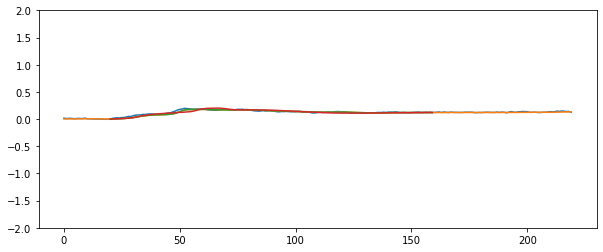

In [50]:
N = len(segment_refined.onset)
i = np.random.randint(N)

on_ = segment_refined.onset[i] 
j = id_nearest_template[i]
Margin_Plot = 20
plt.figure(figsize=(10,4))
plt.plot(tracking_data.body_angle[on_-Margin_Plot:on_+200]-tracking_data.body_angle[on_])
plt.plot(clean_traj.body_angle[on_-Margin_Plot:on_+200]-clean_traj.body_angle[on_])
plt.plot(np.arange(140)+Margin_Plot,traj_array[i,2,:])
plt.plot(np.arange(140)+Margin_Plot,pipeline.knn_training_dataset.traj[j,2,:])
plt.ylim(-2,2)


In [51]:
templates_labels = pipeline.knn_training_dataset.labels
print(traj_array.shape)

(14714, 3, 140)


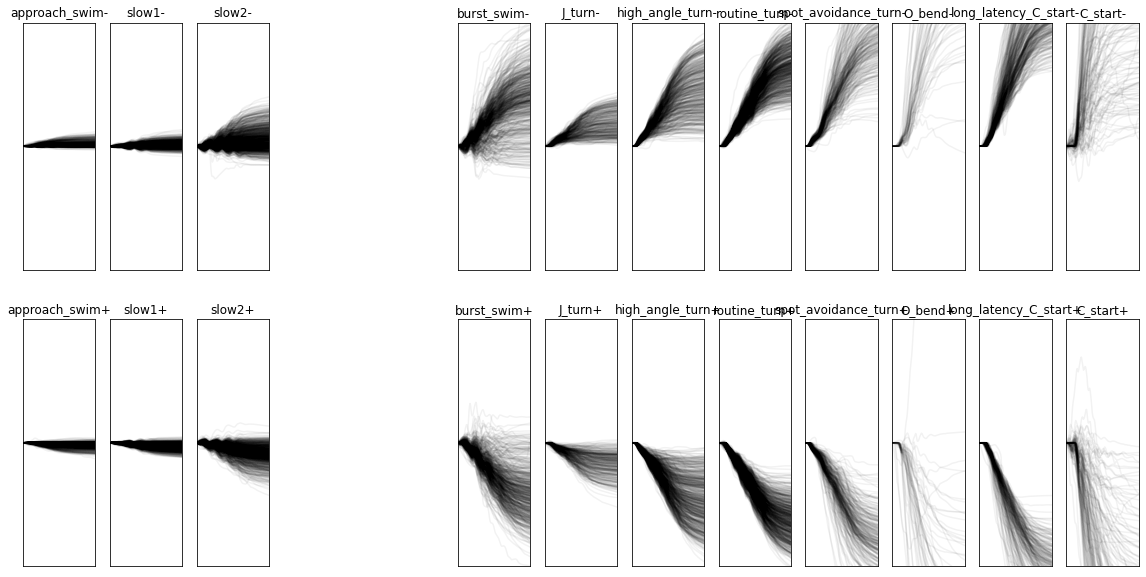

In [52]:

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    
    id = np.where(bout_category==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(traj_array[id,1,:].T,'k',alpha=0.05)

    ax0.set_xlim(0,cfg_segment_classify.bout_duration)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


# Compare with Matlab pipeline

In [61]:
from utils.utils_bouts import compute_bout_cat_ts
from classification.benchmark_w_matlab import compute_bout_cat_matlab
from scipy import stats


In [62]:
bout_cat_ts,bout_cat_ts_signed = compute_bout_cat_ts(segment_refined.onset,segment_refined.offset,bout_category,tracking_data.n_frames)


In [63]:
onset_mat,offset_mat,bout_cat_matlab,bout_cat_ts_matlab,bout_cat_ts_signed_matlab = compute_bout_cat_matlab(df,fps_new=fps_new,fps_old=700)

label_mat = []
label_py = []

for i,(on_,off_) in enumerate(zip(onset_mat,offset_mat)):
    tmp = bout_cat_ts[on_:off_]
    tmp = tmp[tmp>-1]
    if len(tmp)>0:
        label_mat.append(bout_cat_matlab[i])
        label_py.append(stats.mode(tmp)[0][0])

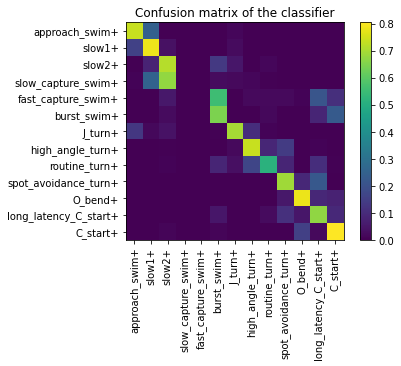

In [78]:
from sklearn.metrics import confusion_matrix
x = np.array(label_mat)
y = np.array(label_py)

cm = confusion_matrix(x, y, labels = np.arange(13),normalize='true')#{‘true’, ‘pred’, ‘all’,'none})
plt.imshow(cm)
plt.title('Confusion matrix of the classifier')
plt.colorbar()
plt.xticks(np.arange(13),NameCat[0:13],rotation=90)
plt.yticks(np.arange(13),NameCat[0:13],rotation=0)
plt.show()

In [79]:
# Accuracy:
x_noCS = x[(x!=3)&(x!=4)]
y_noCS = y[(x!=3)&(x!=4)]

In [80]:
from sklearn.metrics import f1_score
f1_score(x_noCS, y_noCS, average='macro')

0.5753903037533409

In [81]:
from sklearn.metrics import accuracy_score
accuracy_score(x_noCS, y_noCS)

0.6850707750058653

In [82]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(x_noCS, y_noCS)

0.7061829909853767


* 0.49 with KNN 5 SCALE 0 0 2
* 0.68.5 with KNN 5 SCALE 0.4 0.4 2
* 0.68 with KNN 1 SCALE 0.4 0.4 2
* 0.69 with KNN 50 SCALE 0.4 0.4 2
* 0.723 with KNN 50 SCALE 0.4 0.4 2 Delay -10,20


In [53]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

from utils.utils_plot import list_color_w_CS
cmp_bouts = colors.ListedColormap(['#FFFFFF'] + list_color_w_CS)
cmp_bouts_pltly = matplotlib_to_plotly(cmp_bouts, 255)


In [79]:

Duration = fps_new*7
IdSt = 7969693#
IdSt = np.random.randint(mobility.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/fps_new,Duration)
sub_onset,sub_offset,sub_i= [],[],[]

for i,(on_,off_) in enumerate(zip(segment_refined.onset,segment_refined.offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)

sub_i = np.array(sub_i)

sub_traj_array = traj_array[sub_i,:,:]
id = id_nearest_template[sub_i]
traj_nearest = pipeline.knn_training_dataset.traj[id,:,:]

In [80]:
tail_angle.shape
bout_duration = cfg_segment_classify.bout_duration

(0.0, 7.0)

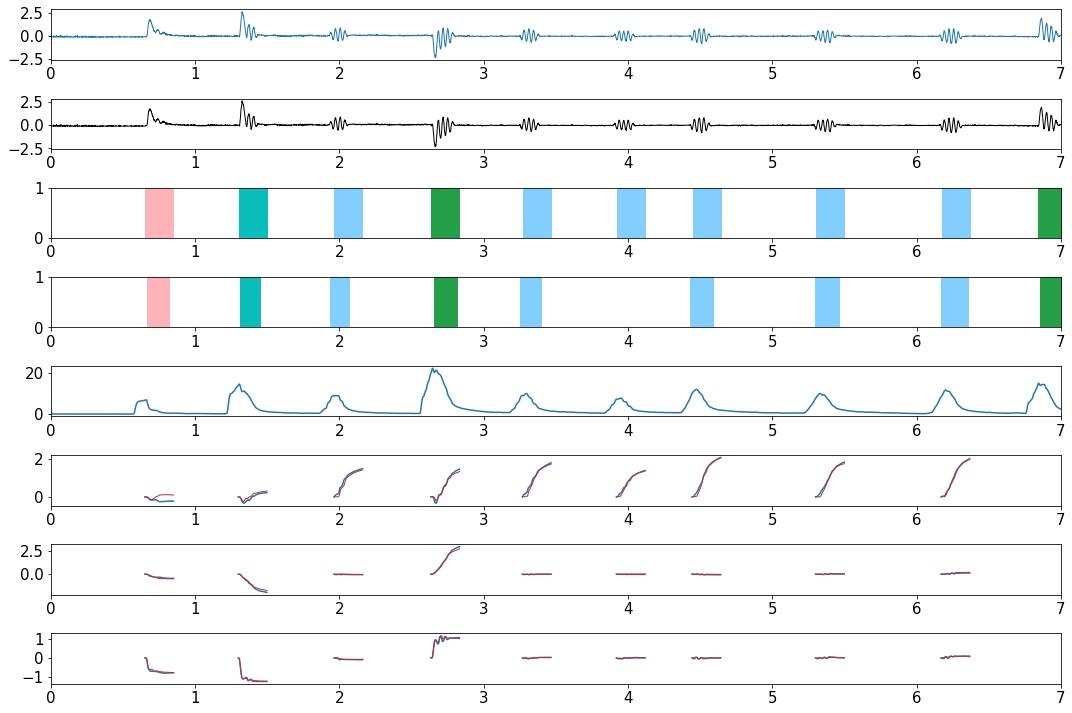

In [81]:

fig, ax = plt.subplots(facecolor='white',figsize=(15,10),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(8,1)

ax = plt.subplot(G[0])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
ax.plot(t,tail_angle[IdSt:IdEd,7],lw=1)
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[1])
ax.plot(t,tail_angle_sub[IdSt:IdEd,7],'k',lw=1)
#ax.plot(t,yaw_speed[IdSt:IdEd],lw=1)
#ax.plot(t,yaw_speed_hat_[IdSt:IdEd],lw=1)
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[2])
ax.imshow(bout_cat_ts[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/fps_new,0,1])
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[3])
ax.imshow(bout_cat_ts_matlab[IdSt:IdEd,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[0,Duration/fps_new,0,1])
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[4])
ax.plot(t,mobility[IdSt:IdEd])
#y =-(1-2*(np.max((z[IdSt:IdEd]),axis=1)>np.max(-(z[IdSt:IdEd]),axis=1)))*np.max(np.abs(z[IdSt:IdEd]),axis=1)*peaks_bin[IdSt:IdEd]
#ax.scatter(t[sub_peaks],y[sub_peaks],color = 'r')
#for p in sub_peaks:
#    ax.add_patch(Rectangle((t[p],-10),140/700,20,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps_new)


ax = plt.subplot(G[5])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,0,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,0,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)

ax = plt.subplot(G[6])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,1,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)


ax = plt.subplot(G[7])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,sub_traj_array[i,2,:],'tab:blue')
    off_ = on_+bout_duration
    ax.plot((np.arange(on_,off_)-IdSt)/fps_new,traj_nearest[i,2,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps_new)

# Save to Plotly

In [ ]:
t = np.arange(0,len(mobility))

fig = make_subplots(rows=3, cols=1,shared_xaxes=True)


for pl in px.imshow(bout_cat_signed.T, x=t, y=np.arange(2)).data:
    fig.add_trace(pl, row=1, col=1)

for pl in px.imshow(df.bout_cat_matlab.values[np.newaxis,:], x=t, y=np.arange(1)).data:
    fig.add_trace(pl, row=2, col=1)


fig.add_trace(go.Scatter(x=t, y=mobility,mode='lines'),
              row=3, col=1)

layout = px.imshow(bout_cat_signed.T,x= t,color_continuous_scale=cmp_bouts_pltly,zmin=-1,zmax=12).layout
fig.layout.coloraxis = layout.coloraxis

fig.update_traces(xaxis="x")

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.write_html("super_resolution_pipeline.html")
